In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Epoch 1/10, Train Loss: 0.7107, Val Loss: 0.6864
Epoch 2/10, Train Loss: 0.7189, Val Loss: 0.6974
Epoch 3/10, Train Loss: 0.6481, Val Loss: 0.6253
Epoch 4/10, Train Loss: 0.6693, Val Loss: 0.6242
Epoch 5/10, Train Loss: 0.6580, Val Loss: 0.6301


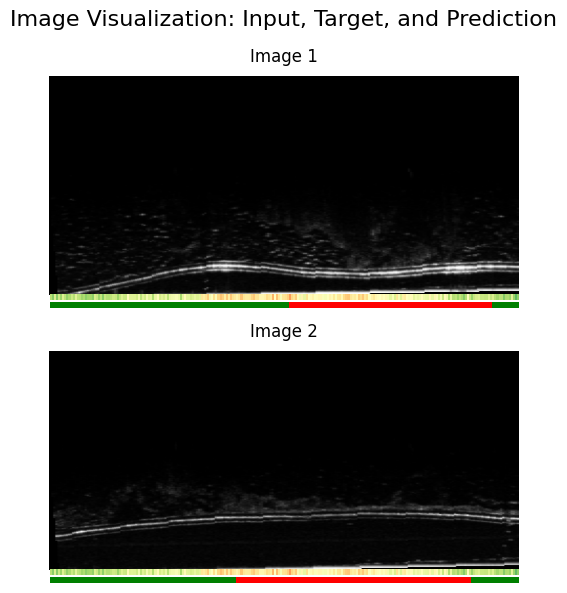

Epoch 6/10, Train Loss: 0.5989, Val Loss: 0.6393
Epoch 7/10, Train Loss: 0.6479, Val Loss: 0.6560
Epoch 8/10, Train Loss: 0.6286, Val Loss: 0.5881
Epoch 9/10, Train Loss: 0.6544, Val Loss: 0.6215
Epoch 10/10, Train Loss: 0.6063, Val Loss: 0.6696


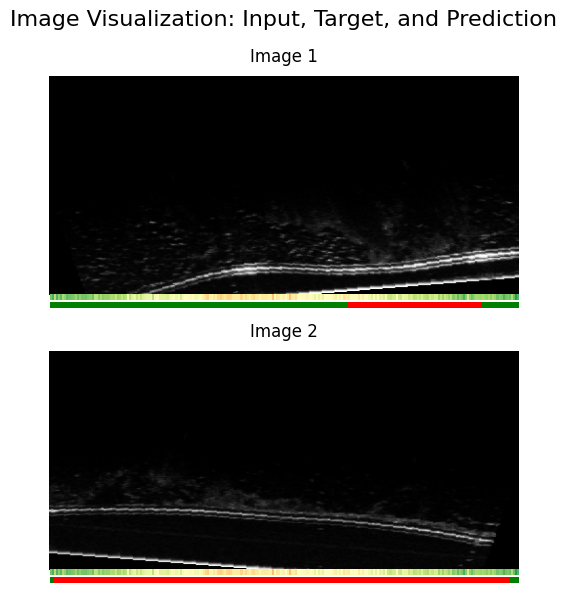

In [46]:
# Custom Dataset
def random_labeling(length):
    idx = np.random.randint(0, length, 2)
    rnd_label = torch.zeros((length)).float()
    rnd_label[min(idx):max(idx)] = 1
    return rnd_label

class TIFDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('L')  # Open as grayscale
        
        if self.transform:
            image = self.transform(image)
        
        # Assuming the target is a vector of length equal to image width
        # target = torch.randint(2, (image.shape[2],)).float()
        target = random_labeling(image.shape[2])
        
        return image, target

class convblock(nn.Module):
    def __init__(self, k_conv, ch_in, ch_out, k_pool, stride, pad, p_drop=0.5):
        super(convblock, self).__init__()
        self.cnn = nn.Sequential(nn.Conv2d(ch_in, ch_out, kernel_size=k_conv, stride=stride, padding=pad), 
                                 nn.ReLU(), 
                                 nn.BatchNorm2d(ch_out),
                                 nn.Dropout2d(p_drop)
                                 )
        self.pool = nn.MaxPool2d(k_pool)

    def forward(self, x):
        x = self.cnn(x)
        y = self.pool(x)
        return y

class CNN(nn.Module):
    def __init__(self, channels, label_dim, image_dim, z_dim):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.p_drop = 0.5
        self.image_dim = image_dim
        output_dim = image_dim

        for i in range(len(channels)-1):
            input_size = output_dim
            ch_in = channels[i]
            ch_out = channels[i+1]
            k_conv = 3
            k_pool = 2
            stride = 1
            pad = (input_size * (stride - 1) - stride + k_conv) // 2 #so that input_size = output_size

            cnn_layer = convblock(k_conv, ch_in, ch_out, k_pool, stride, pad, self.p_drop)
            self.conv_layers.append(cnn_layer)
            output_dim = ((input_size + 2*pad - k_conv)//stride + 1) // k_pool # the output image dimension

        # classifier
        self.fc = nn.Sequential(
            nn.Linear(ch_out*output_dim**2, z_dim),
            nn.Sigmoid(),
            nn.Dropout1d(self.p_drop / 2),
            nn.Linear(z_dim, label_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_size = x.size(0)

        for conv in self.conv_layers:
            x = conv(x)

        x = x.view(batch_size, -1)  # Flatten the output for fully connected layers

        y = self.fc(x)

        return y

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(val_loader)

def visualize_batch(model, dataloader, device, num_images=5):
    model.eval()
    images, targets = next(iter(dataloader))
    images, targets = images.to(device), targets.to(device)

    num_images = min(len(images), num_images)
    
    with torch.no_grad():
        outputs = model(images)
    
    # Convert tensors to numpy for plotting
    images = images.cpu().numpy()
    targets = targets.cpu().numpy()
    outputs = outputs.cpu().numpy()
    
    fig, axes = plt.subplots(num_images, 1, figsize=(5, 3*num_images))
    fig.suptitle("Image Visualization: Input, Target, and Prediction", fontsize=16)
    if num_images == 1:
        axes = [axes]
    
    for i in range(num_images):
        # Plot original image
        axes[i].imshow(images[i, 0], cmap='gray', aspect='auto')
        axes[i].set_title(f"Image {i+1}")
        
        # Add thin rectangles for targets above the image
        for j, target in enumerate(targets[i]):
            color = 'red' if target == 1 else 'green'
            rect = patches.Rectangle((j, -14), 1, 6, linewidth=0, edgecolor=None, facecolor=color)
            axes[i].add_patch(rect)
        
        # Add thin rectangles for predictions below the image
        for j, pred in enumerate(outputs[i]):
            color = plt.cm.RdYlGn(1 - pred)  # Use RdYlGn colormap: red for 1, green for 0
            rect = patches.Rectangle((j, -6), 1, 6, linewidth=0, edgecolor=None, facecolor=color)
            axes[i].add_patch(rect)
        
        axes[i].set_ylim(-14, 230)  # Adjust y-axis to show both target and prediction rectangles
        axes[i].axis('off')
        
        # Add a text annotation to explain the color coding
        # axes[i].text(1.02, 0.5, 'Prediction (top)\nTruth (bottom)', transform=axes[i].transAxes,
        #              verticalalignment='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ])
    
    # Create datasets
    data_folder = '/home/dkari2/Desktop/MarginDx/Python_Codes/fake_data'
    train_dataset = TIFDataset(data_folder+'/tr_data', transform=transform)
    val_dataset = TIFDataset(data_folder+'/val_data', transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    
    image_dim = train_dataset[0][0].shape[2]  # Width of the image
    z_dim = 256
    channels = [1, 32, 32, 64]
    label_dim = image_dim
    model = CNN(channels, label_dim, image_dim, z_dim).to(device)
    
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary targets
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if (epoch + 1) % 5 == 0:
            visualize_batch(model, val_loader, device)

if __name__ == "__main__":
    main()


fix the problem of image showing.